## Imports

In [1]:
import numpy as np
import tensorflow
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import vis_helper as v

2022-03-22 08:43:17.427519: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/openvino_2021/data_processing/dl_streamer/lib:/opt/intel/openvino_2021/data_processing/gstreamer/lib:/opt/intel/openvino_2021/opencv/lib:/opt/intel/openvino_2021/deployment_tools/ngraph/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib::/opt/intel/openvino_2021/deployment_tools/inference_engine/external/hddl/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/omp/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/gna/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/mkltiny_lnx/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/lib/intel64
2022-03-22 08:43:17.427539: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore ab

## Prepare dataset

In [2]:
X1 = [(x+1)*2 for x in range(32)]
X2 = [(x+1)*3 for x in range(32)]
Y = [x1*x2 for x1,x2 in zip(X1,X2)]

X = np.column_stack((X1, X2))

X = np.array(X).reshape(32, 1, 2)
Y = np.array(Y)

print("X: ", X)
print("Y: ", Y)

X:  [[[ 2  3]]

 [[ 4  6]]

 [[ 6  9]]

 [[ 8 12]]

 [[10 15]]

 [[12 18]]

 [[14 21]]

 [[16 24]]

 [[18 27]]

 [[20 30]]

 [[22 33]]

 [[24 36]]

 [[26 39]]

 [[28 42]]

 [[30 45]]

 [[32 48]]

 [[34 51]]

 [[36 54]]

 [[38 57]]

 [[40 60]]

 [[42 63]]

 [[44 66]]

 [[46 69]]

 [[48 72]]

 [[50 75]]

 [[52 78]]

 [[54 81]]

 [[56 84]]

 [[58 87]]

 [[60 90]]

 [[62 93]]

 [[64 96]]]
Y:  [   6   24   54   96  150  216  294  384  486  600  726  864 1014 1176
 1350 1536 1734 1944 2166 2400 2646 2904 3174 3456 3750 4056 4374 4704
 5046 5400 5766 6144]


## Hyperparameters

In [3]:
EPOCHS = 2000
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

## Solutions via single LSTM

In [4]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, X.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

2022-03-22 08:43:18.761422: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-22 08:43:18.761599: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/openvino_2021/data_processing/dl_streamer/lib:/opt/intel/openvino_2021/data_processing/gstreamer/lib:/opt/intel/openvino_2021/opencv/lib:/opt/intel/openvino_2021/deployment_tools/ngraph/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib::/opt/intel/openvino_2021/deployment_tools/inference_engine/external/hddl/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/omp/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/gna/lib:/opt/intel/openvino_2021/deployment_tools/inference_engine/external/mkltiny_lnx/lib:/opt/intel/openvino_2021/deployment

In [5]:
model.compile(optimizer='adam', loss='mse', metrics='mae')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10600     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 11,121
Trainable params: 11,121
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x=X, y=Y, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE, verbose=0)

2022-03-22 08:43:18.869123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-22 08:43:18.887523: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2803200000 Hz


## Training Plot

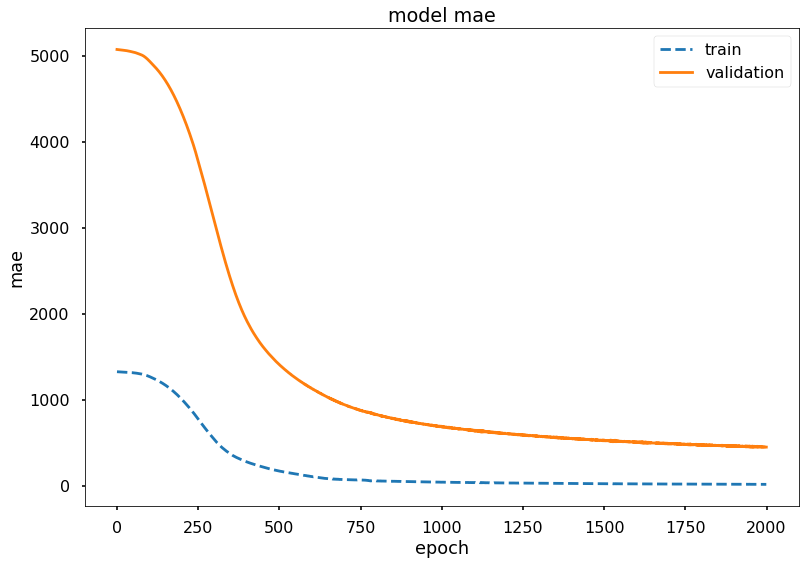

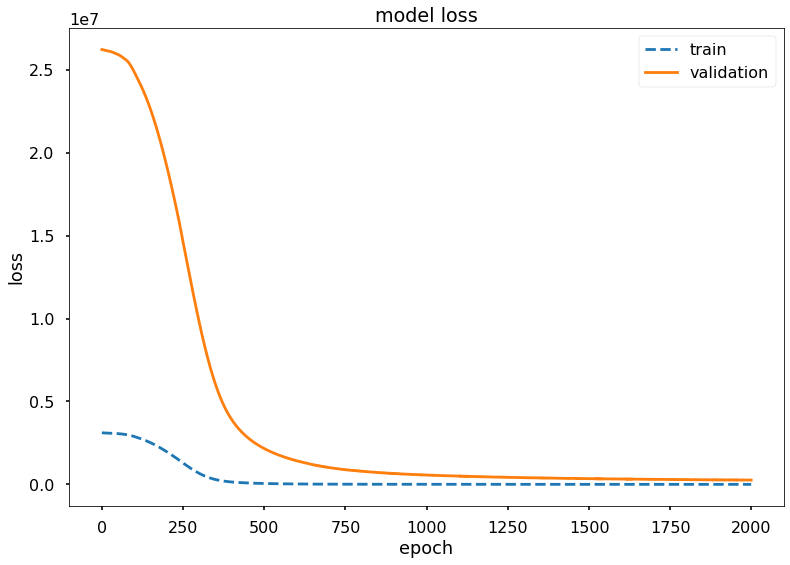

In [8]:
v.plot(history)

## Prediction

In [9]:
test_input = np.array([55, 80])
test_input = test_input.reshape((1, 1, 2))
test_output = model.predict(test_input, verbose=0)
print("Actual output: ", test_input[0, 0, 0]*test_input[0, 0, 1])
print("Predicted output: ", test_output)

Actual output:  4400
Predicted output:  [[4125.116]]


## Solution via Stacked LSTM

In [10]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile( optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 200)            162400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            120400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [11]:
model.compile(optimizer='adam', loss='mse', metrics='mae')

In [12]:
history = model.fit(x=X, y=Y, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE, verbose=0)

## Training Plot

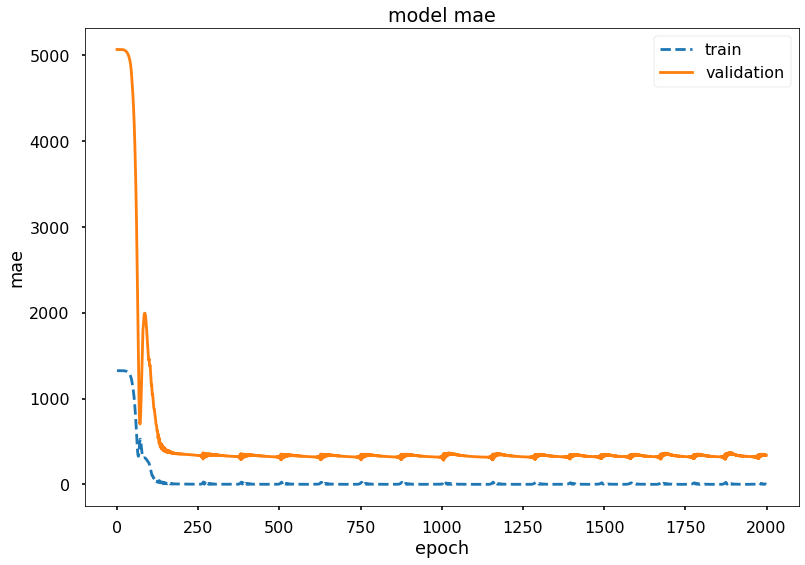

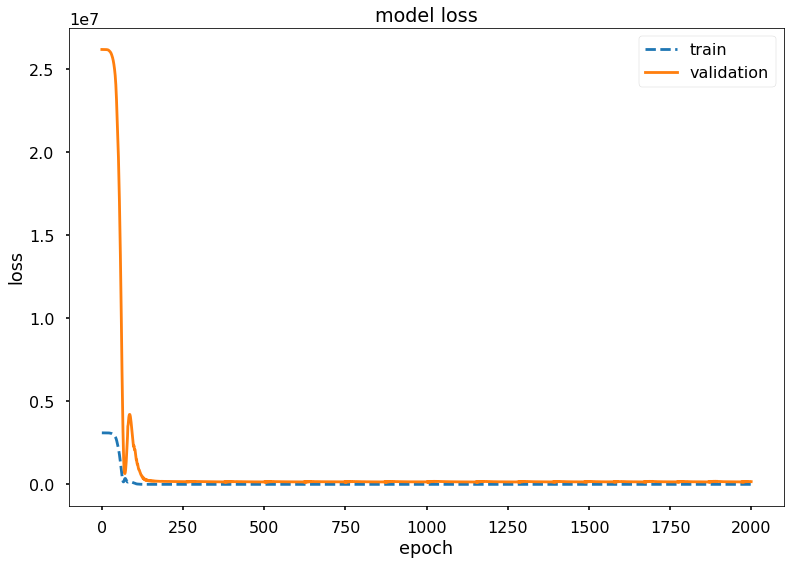

In [13]:
v.plot(history)

## Prediction

In [14]:
test_input = np.array([55,80])
test_input = test_input.reshape((1, 1, 2))
test_output = model.predict(test_input, verbose=0)
print("Actual output: ", test_input[0, 0, 0]*test_input[0, 0, 1])
print("Predicted output: ", test_output)

Actual output:  4400
Predicted output:  [[4250.79]]
